# Bayesian Inference --> Linear Regression

  0%|          | 0/10000 [00:00<?, ?it/s]

13:21 bilby INFO    : Running for label 'linear_regression_grid', output will be saved to '.'


Brute force ln_evidence: -240.4875819510436


13:21 bilby INFO    : Analysis priors:
13:21 bilby INFO    : m=Uniform(minimum=0, maximum=4, name='m', latex_label='m', unit=None, boundary=None)
13:21 bilby INFO    : c=Uniform(minimum=-2, maximum=2, name='c', latex_label='c', unit=None, boundary=None)
13:21 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
13:21 bilby INFO    : Analysis likelihood noise evidence: nan
13:21 bilby INFO    : Single likelihood evaluation took 1.005e-04 s
13:21 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 500, 'bound': 'multi', 'sample': 'unif', 'periodic': None, 'reflective': None, 'update_interval': None, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'gradient': None, 'grad_args': None, 'grad_kwargs': None, 'compute_jac': False, 'enlarge': None, 'bootstrap': None, 'walks': 100, 'facc': 0

1it [00:00, ?it/s]

13:21 bilby INFO    : Written checkpoint file ./linear_regression_grid_resume.pickle


13:21 bilby INFO    : Sampling time: 0:00:10.629446
13:21 bilby INFO    : Summary of results:
nsamples: 3864
ln_noise_evidence:    nan
ln_evidence: -246.872 +/-  0.105
ln_bayes_factor:    nan +/-  0.105

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Brute force ln_evidence: -240.4875819510436
Sampler ln_evidence: -246.8722829649333


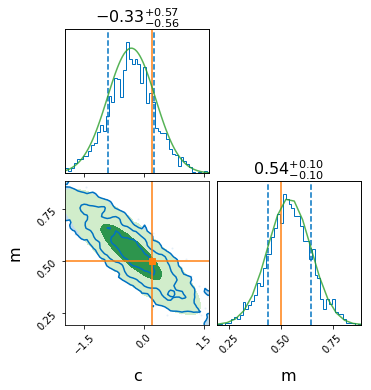

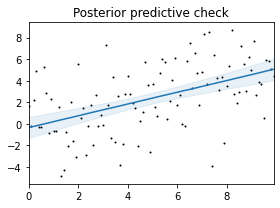

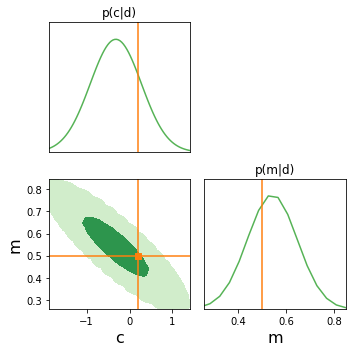

In [1]:
import bilby
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from corner.core import quantile

np.random.seed(42)

# A few simple setup steps
label = "linear_regression_grid"
outdir = "."


# First, we define our "signal model", in this case a simple linear function
def model(time, m, c):
    return time * m + c


# Now we define the injection parameters which we make simulated data with
injection_parameters = dict()
injection_parameters["c"] = 0.2
injection_parameters["m"] = 0.5

# For this example, we'll use standard Gaussian noise

# These lines of code generate the fake data. Note the ** just unpacks the
# contents of the injection_parameters when calling the model function.
sampling_frequency = 10
time_duration = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
N = len(time)
sigma = 3.0
data = model(time, **injection_parameters) + np.random.normal(0, sigma, N)

# We quickly plot the data to check it looks sensible
fig, ax = plt.subplots()
ax.plot(time, data, "o", label="data", color='k')
ax.plot(time, model(time, **injection_parameters), "--r", label="signal")
ax.set_xlabel("time")
ax.set_ylabel("y")
ax.legend()
fig.savefig("{}/{}_data.png".format(outdir, label))

# Now lets instantiate a version of our GaussianLikelihood, giving it
# the time, data and signal model
likelihood = bilby.likelihood.GaussianLikelihood(time, data, model, sigma)


# We make a prior


def get_m_c_prior():
    priors = bilby.core.prior.PriorDict(dict(
        m=bilby.core.prior.Uniform(0, 4, "m"),
        c=bilby.core.prior.Uniform(-2, 2, "c"),
    ))
    return priors


m_c_prior = get_m_c_prior()


def get_grid_of_m_c(n_samples):
    prior = get_m_c_prior()
    n_per_dim = int(np.ceil(n_samples ** (1 / len(prior))))
    m_vals = np.linspace(prior['m'].minimum, prior['m'].maximum, n_per_dim)
    c_vals = np.linspace(prior['c'].minimum, prior['c'].maximum, n_per_dim)
    m_grid, c_grid = np.meshgrid(m_vals, c_vals)
    return pd.DataFrame(dict(m=m_grid.flatten(), c=c_grid.flatten()))


def brute_force_run(likelihood, prior, n_samples):
    grid = get_grid_of_m_c(n_samples=n_samples)
    n_samples = len(grid)
    log_likelihoods = np.zeros(n_samples)
    log_priors = np.zeros(n_samples)
    for i in tqdm(range(n_samples)):
        sample = grid.iloc[i].to_dict()
        likelihood.parameters = sample
        log_likelihoods[i] = likelihood.log_likelihood()
        log_priors[i] = prior.ln_prob(sample)
    log_evidence = np.logaddexp.reduce(log_likelihoods + log_priors)
    grid["log_posterior"] = (log_likelihoods + log_priors) - log_evidence
    grid["log_prior"] = log_priors
    grid["log_likelihood"] = log_likelihoods
    print("Brute force ln_evidence: {}".format(log_evidence))
    return grid, log_evidence


def get_marginalised_posterior(parameter, grid):
    unique_values = np.unique(grid[parameter])
    log_posterior = np.zeros(len(unique_values))
    for i, value in enumerate(unique_values):
        log_posterior[i] = np.logaddexp.reduce(grid[grid[parameter] == value]["log_posterior"])
    return unique_values, np.exp(log_posterior)


def sampler_run():
    # And run sampler
    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=get_m_c_prior(),
        sampler="dynesty",
        nlive=500,
        sample="unif",
        injection_parameters=injection_parameters,
        outdir=outdir,
        label=label,
    )
    return result


def plot_grid(grid, injection_parameters=None, axes=None, save=False):
    m_vals, p_m = get_marginalised_posterior("m", grid)
    c_vals, p_c = get_marginalised_posterior("c", grid)
    n_cells = int(np.sqrt(len(grid)))
    m_grid = grid['m'].values.reshape(n_cells, n_cells)
    c_grid = grid['c'].values.reshape(n_cells, n_cells)
    posterior_grid = np.exp(grid['log_posterior'].values.reshape(n_cells, n_cells))
    posterior_grid = posterior_grid / np.sum(posterior_grid)

    if axes is None:
        fig, axes = plt.subplots(2, 2, figsize=(5,5))
        axes = axes.flatten()
        axes[1].axis("off")

    fig = axes[0].figure
    c_axis = axes[0]
    m_c_axis = axes[2]
    m_axis = axes[3]

    m_axis.plot(m_vals, p_m, color="tab:green", alpha=0.8)
    c_axis.plot(c_vals, p_c, color="tab:green", alpha=0.8)
    m_axis.set_ylim(0, 1.15 * np.max(p_m))
    c_axis.set_ylim(0, 1.15 * np.max(p_c))
    m_c_axis.contourf(c_grid, m_grid, posterior_grid, levels=np.quantile(posterior_grid, [0.95, 0.99, 1]), cmap="Greens")

    for axi in [c_axis, m_axis]:
        axi.set_yticks([])

    if injection_parameters is not None:
        m_axis.axvline(injection_parameters["m"], color="tab:orange", )
        c_axis.axvline(injection_parameters["c"], color="tab:orange", )
        m_c_axis.axhline(injection_parameters["m"], color="tab:orange", )
        m_c_axis.axvline(injection_parameters["c"], color="tab:orange", )
        m_c_axis.scatter(injection_parameters["c"], injection_parameters["m"], color="tab:orange", marker='s')

    if save:
        # zoom in on the region of interest
        m_quan = quantile(m_vals, [0.002, 0.998], weights=p_m)
        c_quan = quantile(c_vals, [0.002, 0.998], weights=p_c)
        m_axis.set_xlim(m_quan)
        c_axis.set_xlim(c_quan)
        m_c_axis.set_xlim(c_quan)
        m_c_axis.set_ylim(m_quan)
        c_axis.set_xticks([])
        m_axis.set_xlabel("m", fontsize=16)
        m_c_axis.set_ylabel("m", fontsize=16)
        m_c_axis.set_xlabel("c", fontsize=16)
        m_axis.set_title(f"p(m|d)")
        c_axis.set_title(f"p(c|d)")
        fig.tight_layout()
        fig.savefig("brute_force.png")


def overplot_sampler_and_brute_force(sampler_result, grid, injection_parameters):
    n_sampler = len(sampler_result.posterior)
    n_grid = len(np.unique(grid["m"]))
    weights = np.ones(n_sampler) * (n_grid / n_sampler)
    fig = sampler_result.plot_corner(parameters=injection_parameters, save=False, weights=weights)
    # overplot the grid estimates
    axes = fig.axes
    for axi in [0, 3]:
        axes[axi] = axes[axi].twinx()
        axes[axi].set_yticks([])
    grid_ln_evidence = np.logaddexp.reduce(grid["log_likelihood"] + grid["log_prior"])
    plot_grid(grid, axes=axes, save=False)
    fig.savefig("comparison.png", dpi=300)
    print("Brute force ln_evidence: {}".format(grid_ln_evidence))
    print("Sampler ln_evidence: {}".format(sampler_result.log_evidence))


def plot_posterior_predictive_check(
    observed_data,
    time,
    model,
    posterior,
):
    # take 100 random samples from the posterior
    post = posterior.sample(1000)
    m, c = post['m'].values, post['c'].values
    ys = np.array([model(time, mi, ci) for mi, ci in zip(m, c)]).T
    y_low, y_mean, y_up = np.quantile(ys, [0.05, 0.5, 0.95], axis=1)

    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.scatter(time, observed_data, color="k", zorder=-10, s=1)
    ax.plot(time, y_mean, color="tab:blue")
    ax.fill_between(time, y_low, y_up, alpha=0.1, color="tab:blue")
    ax.set_xlim(time.min(), time.max())
    plt.title("Posterior predictive check")
    plt.legend(frameon=False)
    plt.tight_layout()
    fig.savefig("posterior_predictive_check.png", dpi=300)


grid, log_evid = brute_force_run(likelihood, m_c_prior, 10000)
sampler_result = sampler_run()
overplot_sampler_and_brute_force(sampler_result, grid, injection_parameters)
plot_posterior_predictive_check(data, time, model, sampler_result.posterior)
plot_grid(grid, injection_parameters, save=True)

## CBC Signal Model

![https://vijayvarma392.github.io/binaryBHexp/movies/aligned.mp4](https://vijayvarma392.github.io/binaryBHexp/movies/aligned.mp4)

image of signal

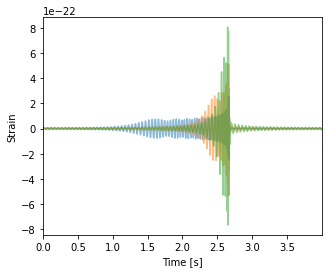

In [2]:
import bilby
from bilby.gw.conversion import chirp_mass_and_mass_ratio_to_component_masses
import matplotlib.pyplot as plt
import numpy as np
import logging

logging.getLogger("bilby").setLevel(logging.ERROR)

OUTDIR = "outdir"


def make_waveform_generator(approximant="IMRPhenomPv2", duration=4, sampling_frequency=1024,
                 frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole, ):
    """Create a waveform generator"""
    generator_args = dict(
            duration=duration,
            sampling_frequency=sampling_frequency,
            frequency_domain_source_model=frequency_domain_source_model,
            waveform_arguments=dict(
                waveform_approximant=approximant,
                reference_frequency=20.,
            )
        )
    return bilby.gw.WaveformGenerator(**generator_args)


def compute_waveform(waveform_generator, signal_parameters={}):
    """Compute the waveform"""
    parameters = dict(
        # two mass parameters
        mass_1=30, mass_2=30,
        # 6 spin parameters
        a_1=0.0, a_2=0.0, tilt_1=0, tilt_2=0, phi_jl=0,phi_12=0,
        # 2 tidal deformation parameters (for NS)
        lambda_1=0, lambda_2=0,
        # 7 extrinsic parameters (skyloc, timing, phase, etc)
        luminosity_distance=2000,
        theta_jn=0, ra=0, dec=0,
        psi=0, phase=0,
        geocent_time=0,
        )
    parameters.update(signal_parameters)
    h = waveform_generator.time_domain_strain(parameters)
    t = waveform_generator.time_array
    approximant = waveform_generator.waveform_arguments["waveform_approximant"]
    delta_t = 1./waveform_generator.sampling_frequency

    if "IMR" in approximant:
        # IMR templates the zero of time is at max amplitude (merger)
        # thus we roll the waveform back a bit
        for pol in h.keys():
            h[pol] = np.roll(h[pol], - len( h[pol])//3)

    h_phase = np.unwrap(np.arctan2(h['cross'], h['plus']))
    h_freq = np.diff(h_phase) / (2 * np.pi * delta_t)
    # nan the freqs after the merger
    h_freq[np.argmax(h_freq):] = np.nan
    return h['plus'], h_freq, t

def plot_waveform(waveform_generator, signal_parameters={}, fig=None):
    h_plus, h_freq, h_time = compute_waveform(waveform_generator, signal_parameters)
    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    else:
        ax = fig.axes[0]
    ax.plot(h_time, h_plus, alpha=0.5)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Strain")
    ax.set_xlim(min(h_time), max(h_time))
    # remove whitespace between subplots
    fig.subplots_adjust(hspace=0)
    return fig

def main():
    waveform_generator = make_waveform_generator(approximant="IMRPhenomPv2")
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    for mc in np.linspace(20, 60, 3):
        m1, m2 = chirp_mass_and_mass_ratio_to_component_masses(mc, 1)
        signal_parameters = dict(mass_1=m1, mass_2=m2)
        plot_waveform(waveform_generator, signal_parameters, fig=fig)
    plt.show()
    fig.savefig('waveform_test.png')


if __name__ == '__main__':
    main()


# CBC Parameter Estimation

346it [00:00, ?it/s]

Exception while calling loglikelihood function:
  params: [27.02526886]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/avaj0001/Documents/projects/deep_gw_pe_followup/venv/lib/python3.9/site-packages/dynesty/dynesty.py", line 896, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
  File "/Users/avaj0001/Documents/projects/deep_gw_pe_followup/venv/lib/python3.9/site-packages/bilby/core/sampler/dynesty.py", line 35, in _log_likelihood_wrapper
    if _sampling_convenience_dump.priors.evaluate_constraints(
  File "/Users/avaj0001/Documents/projects/deep_gw_pe_followup/venv/lib/python3.9/site-packages/bilby/core/prior/dict.py", line 57, in evaluate_constraints
    out_sample = self.conversion_function(sample)
  File "/Users/avaj0001/Documents/projects/deep_gw_pe_followup/venv/lib/python3.9/site-packages/bilby/gw/prior.py", line 857, in default_conversion_function
    def default_conversion_function(self, sample):
  File "/Users/avaj0001/Documents/projects/deep_gw_pe_followup/venv/lib/python3.9/site-packages/bilby/core/sampler/

SystemExit: 130

/Users/avaj0001/Documents/projects/deep_gw_pe_followup/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


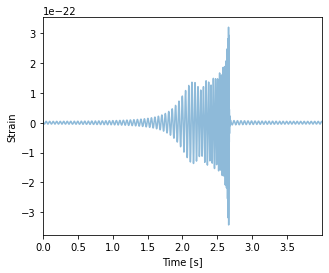

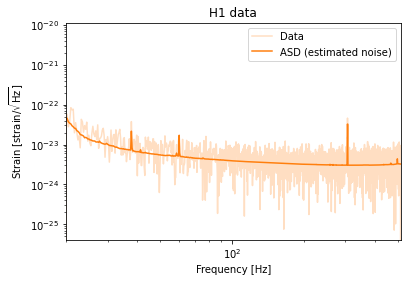

In [3]:
import bilby
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(88170235)
OUTDIR = "outdir"

# Simulate signal
duration, sampling_freq, min_freq = 4, 1024., 20
injection_parameters = dict(
    mass_1=36.0, mass_2=29.0, # 2 mass parameters
    a_1=0.1, a_2=0.1, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0, # 6 spin parameters
    ra=1.375, dec=-1.2108, luminosity_distance=2000.0, theta_jn=0.0, # 7 extrinsic parameters
    psi=2.659, phase=1.3,
    geocent_time=1126259642.413,
)
inj_m1, inj_m2 = injection_parameters['mass_1'], injection_parameters['mass_2']
inj_chirp_mass = bilby.gw.conversion.component_masses_to_chirp_mass(inj_m1, inj_m2 )
inj_q = bilby.gw.conversion.component_masses_to_mass_ratio(inj_m1, inj_m2)


waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_freq,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments= dict(
        waveform_approximant="IMRPhenomD",
        reference_frequency=20.0,
        minimum_frequency=min_freq,
    )
)

fig = plot_waveform(waveform_generator, injection_parameters)




# Inject the signal into 1 detectors LIGO-Hanford (H1) at design sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_freq,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 2,
)
ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)


for interferometer in ifos:
    analysis_data = abs(interferometer.frequency_domain_strain)
    fig = plt.figure()
    plt.loglog(interferometer.frequency_array, analysis_data, label="Data", color="tab:orange", alpha=0.25)
    plt.loglog(interferometer.frequency_array, abs(interferometer.amplitude_spectral_density_array),
               label="ASD (estimated noise)", color="tab:orange")
    plt.xlim(interferometer.minimum_frequency, interferometer.maximum_frequency)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel(r'Strain [strain/$\sqrt{\rm Hz}$]')
    plt.title(f"{interferometer.name} data")
    plt.legend()



# Set up a PriorDict, which inherits from dict.
# By default we will sample all terms in the signal models.  However, this will
# take a long time for the calculation, so for this example we will set almost
# all of the priors to be equall to their injected values.  This implies the
# prior is a delta function at the true, injected value.  In reality, the
# sampler implementation is smart enough to not sample any parameter that has
# a delta-function prior.
# The above list does *not* include mass_1, mass_2, theta_jn and luminosity
# distance, which means those are the parameters that will be included in the
# sampler.  If we do nothing, then the default priors get used.
priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
    "theta_jn",
    "luminosity_distance",
]:
    priors[key] = injection_parameters[key]
priors["mass_ratio"] = inj_q
priors["chirp_mass"] = bilby.gw.prior.UniformInComponentsChirpMass(minimum=inj_chirp_mass-5, maximum=inj_chirp_mass+5)


# Perform a check that the prior does not extend to a parameter space longer than the data
priors.validate_prior(duration, min_freq)

# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator,
)

# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    npoints=250,
    nlive=100, walks=25,
    dlogz=0.1,
    injection_parameters=injection_parameters,
    outdir=OUTDIR,
    label="injection",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    result_class=bilby.gw.result.CBCResult,
)


result.plot_corner(parameters=["mass_1", "mass_2"], truths=[inj_m1, inj_m2])

result = bilby.gw.result.CBCResult.from_json(outdir=OUTDIR, label="injection")
for interferometer in ifos:
    fig = result.plot_interferometer_waveform_posterior(
        interferometer=interferometer, save=False
    )
    plt.show()




In [ ]:
# lets clear up some memory before proceeding to the next section!
del result
del ifos

# Analysis of GW150914

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import bilby

from bilby import run_sampler

from bilby.core.prior import Constraint, Uniform

from bilby.gw.conversion import (
    convert_to_lal_binary_black_hole_parameters,
    generate_all_bbh_parameters
)
from bilby.gw.detector.networks import InterferometerList
from bilby.gw.detector.psd import PowerSpectralDensity
from bilby.gw.likelihood import GravitationalWaveTransient
from bilby.gw.prior import BBHPriorDict
from bilby.gw.result import CBCResult
from bilby.gw.source import lal_binary_black_hole
from bilby.gw.utils import get_event_time
from bilby.gw.waveform_generator import WaveformGenerator
from gwpy.plot import Plot as GWpyPlot
from gwpy.timeseries import TimeSeries
import os

OUTDIR = "outdir"
os.makedirs(OUTDIR, exist_ok=True)

interferometers = InterferometerList(["H1", "L1"])
trigger_time = get_event_time("GW150914")

start_time = trigger_time - 3
duration = 4
end_time = start_time + duration
roll_off = 0.2

# Get raw data
raw_data = {}
for interferometer in interferometers:
    print(
        "Getting analysis segment data for {}".format(interferometer.name)
    )
    analysis_data = TimeSeries.fetch_open_data(
        interferometer.name, start_time, end_time
    )
    interferometer.strain_data.roll_off = roll_off
    interferometer.strain_data.set_from_gwpy_timeseries(analysis_data)
    raw_data[interferometer.name] = analysis_data

# plot raw data:
plot = GWpyPlot(figsize=(12, 4.8))
ax = plot.add_subplot(xscale='auto-gps')
for ifo_name, data in raw_data.items():
    ax.plot(data, label=ifo_name)
ax.set_epoch(1126259462.427)
ax.set_xlim(1126259462, 1126259462.6)
ax.set_ylabel('Strain noise')
ax.legend()
plot.show()

# recall Dan Browns talk -- keep only data in 50-250 Hz and remove 60 Hz and 120 Hz (the 'violin modes')
# plot of Noise
# plot raw data after some basic filtering
plot = GWpyPlot(figsize=(12, 4.8))
ax = plot.add_subplot(xscale='auto-gps')
for ifo_name, data in raw_data.items():
    filtered_data = data.bandpass(50, 250).notch(60).notch(120)
    ax.plot(filtered_data, label=ifo_name)
ax.set_epoch(1126259462.427)
ax.set_xlim(1126259462, 1126259462.6)
ax.set_ylim(-1e-21, 1e-21)
ax.set_ylabel('Strain noise')
ax.legend()
plot.show()

# Get data for noise estimation -- the power spectral density (PSD)
psd_start_time = start_time + duration
psd_duration = 128
psd_end_time = psd_start_time + psd_duration
psd_tukey_alpha = 2 * roll_off / duration
overlap = duration / 2

for interferometer in interferometers:
    print("Getting psd segment data for {}".format(interferometer.name))
    psd_data = TimeSeries.fetch_open_data(
        interferometer.name, psd_start_time, psd_end_time
    )
    psd = psd_data.psd(
        fftlength=duration, overlap=overlap, window=("tukey", psd_tukey_alpha),
        method="median"
    )
    interferometer.power_spectral_density = PowerSpectralDensity(
        frequency_array=psd.frequencies.value, psd_array=psd.value
    )

for interferometer in interferometers:
    analysis_data = abs(interferometer.frequency_domain_strain)
    plt.loglog(interferometer.frequency_array, analysis_data, label="Analysis Data")
    plt.loglog(interferometer.frequency_array, abs(interferometer.amplitude_spectral_density_array),
               label="ASD (estimated noise)")
    plt.xlim(interferometer.minimum_frequency, interferometer.maximum_frequency)
    ymin_max = [min(analysis_data), max(analysis_data)]
    plt.vlines([60, 120], *ymin_max, ls="--", color='k', zorder=-10)
    plt.fill_betweenx(ymin_max, 50, 250, color='tab:green', alpha=0.1)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel(r'Strain [strain/$\sqrt{\rm Hz}$]')
    plt.title(f"{interferometer.name} data")
    plt.ylim(*ymin_max)
    plt.legend()
    plt.show()

tc

# setup the prior
from bilby.core.prior import Uniform, PowerLaw, Sine, Constraint, Cosine
from corner import corner
import pandas as pd

# typically we would use a priors with wide bounds:
tc = trigger_time
priors = BBHPriorDict(dict(
    mass_ratio=Uniform(name='mass_ratio', minimum=0.125, maximum=1),
    chirp_mass=Uniform(name='chirp_mass', minimum=25, maximum=31),
    mass_1=Constraint(name='mass_1', minimum=10, maximum=80),
    mass_2=Constraint(name='mass_2', minimum=10, maximum=80),
    a_1=Uniform(name='a_1', minimum=0, maximum=0.99),
    a_2=Uniform(name='a_2', minimum=0, maximum=0.99),
    tilt_1=Sine(name='tilt_1'),
    tilt_2=Sine(name='tilt_2'),
    phi_12=Uniform(name='phi_12', minimum=0, maximum=2 * np.pi, boundary='periodic'),
    phi_jl=Uniform(name='phi_jl', minimum=0, maximum=2 * np.pi, boundary='periodic'),
    luminosity_distance=PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000),
    dec=Cosine(name='dec'),
    ra=Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic'),
    theta_jn=Sine(name='theta_jn'),
    psi=Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic'),
    phase=Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic'),
    geocent_time=Uniform(minimum=tc - 0.1, maximum=tc + 0.1, latex_label="$t_c$", unit="$s$")
))

# however, for this example (to make analysis faster) we will use a prior with tighter bounds
priors['luminosity_distance'] = 419.18
priors['mass_1'] = Constraint(name='mass_1', minimum=30, maximum=50)
priors['mass_2'] = Constraint(name='mass_2', minimum=20, maximum=40)
priors['ra'] = 2.269
priors['dec'] = -1.223
priors['geocent_time'] = tc
priors['theta_jn'] = 2.921
priors['phi_jl'] = 0.968
priors['psi'] = 2.659

prior_samples = priors.sample(10000)
prior_samples_df = pd.DataFrame(prior_samples)
prior_samples_df

parameters = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2']

fig = corner(prior_samples_df[parameters], plot_datapoints=False, plot_contours=False, plot_density=True,
             color="tab:gray")
fig.show()

from bilby.gw.conversion import generate_mass_parameters

prior_samples = generate_mass_parameters(prior_samples)
prior_samples['cos_tilt_1'] = np.cos(prior_samples['tilt_1'])
prior_samples['cos_tilt_2'] = np.cos(prior_samples['tilt_2'])
s1z = prior_samples["a_1"] * prior_samples['cos_tilt_1']
s2z = prior_samples["a_2"] * prior_samples['cos_tilt_2']
q = prior_samples['mass_ratio']
prior_samples['chi_eff'] = (s1z + s2z * q) / (1 + q)
prior_samples_df = pd.DataFrame(prior_samples)
prior_samples_df

parameters = ['mass_1', 'mass_2', 'chi_eff']
fig = corner(prior_samples_df[parameters], plot_datapoints=False, plot_contours=False, plot_density=True,
             color="tab:gray")
fig.show()

waveform_generator = WaveformGenerator(
    duration=interferometers.duration,
    sampling_frequency=interferometers.sampling_frequency,
    frequency_domain_source_model=lal_binary_black_hole,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(
        waveform_approximant="IMRPhenomPv2",
        reference_frequency=20)
)

likelihood = GravitationalWaveTransient(
    interferometers=interferometers, waveform_generator=waveform_generator,
    priors=priors, time_marginalization=False, distance_marginalization=False,
    phase_marginalization=True, jitter_time=False
)

result = run_sampler(
    likelihood=likelihood, priors=priors, save=True,
    label="GW150914",
    nlive=50, walks=25,
    conversion_function=generate_all_bbh_parameters,
    result_class=CBCResult,
)
for interferometer in interferometers:
    fig = result.plot_interferometer_waveform_posterior(
        interferometer=interferometer, save=False
    )
    plt.show()

